In [1]:
!pip install -U git+https://github.com/qubvel/segmentation_models.pytorch
import segmentation_models_pytorch as smp
import albumentations as albu
import segmentation_models_pytorch.utils as smp_utils
import cv2
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torchvision.transforms as T
from torch.utils.data import Dataset
from PIL import Image
import zipfile
import shutil
import random
from tqdm import tqdm
from skimage.filters import threshold_otsu
from IPython.display import clear_output
from sklearn.cluster import DBSCAN

clear_output()

# Датасет

https://www.kaggle.com/datasets/metavision/accurate-matricaria-flower-shapessegmentation

Внушительный по объему датасет с изображениями цветов

In [2]:
! kaggle datasets download -d "metavision/accurate-matricaria-flower-shapessegmentation"
# Распакуем архив
with zipfile.ZipFile("accurate-matricaria-flower-shapessegmentation.zip", 'r') as zip_ref:
  zip_ref.extractall("accurate-matricaria-flower-shapessegmentation")

Dataset URL: https://www.kaggle.com/datasets/metavision/accurate-matricaria-flower-shapessegmentation
License(s): Attribution 4.0 International (CC BY 4.0)
100% 688M/690M [00:36<00:00, 22.7MB/s]
100% 690M/690M [00:36<00:00, 20.0MB/s]


In [3]:
# Сделаю так, что в одной папке 2 подпапки: с картинками цветов и с их масками
source_dir = "accurate-matricaria-flower-shapessegmentation/04-matricaria-01"
target_dir = "dataset"
test_ratio = 0.5
try:
    # Создаем целевую папку, если её нет
    os.makedirs(target_dir, exist_ok=True)


    train_target_image_dir = os.path.join(target_dir, "train", "images")
    train_target_mask_dir = os.path.join(target_dir, "train", "masks")
    test_target_image_dir = os.path.join(target_dir, "test", "images")
    test_target_mask_dir = os.path.join(target_dir, "test", "masks")

    os.makedirs(train_target_image_dir, exist_ok=True)
    os.makedirs(train_target_mask_dir, exist_ok=True)
    os.makedirs(test_target_image_dir, exist_ok=True)
    os.makedirs(test_target_mask_dir, exist_ok=True)


    # Обрабатываем изображения
    image_source = os.path.join(source_dir, "720p")

    if os.path.exists(image_source):
        image_files = sorted(os.listdir(image_source))
        split_index = int(len(image_files) * test_ratio)
        for filename in image_files[:split_index]:
            shutil.move(os.path.join(image_source, filename), train_target_image_dir, filename)
        for filename in image_files[split_index:]:
            shutil.move(os.path.join(image_source, filename), test_target_image_dir)
        print("Изображения распределены между train и test")
    else:
        print(f"Предупреждение: Папка '{image_source}' не найдена.")

    # Обрабатываем маски
    mask_source = os.path.join(source_dir, "mask")
    if os.path.exists(mask_source):
        mask_files = sorted(os.listdir(mask_source))

        for filename in mask_files[:split_index]:
            shutil.move(os.path.join(mask_source, filename), train_target_mask_dir)
        for filename in mask_files[split_index:]:
            shutil.move(os.path.join(mask_source, filename), test_target_mask_dir)
        print("Маски распределены между train и test")
    else:
        print(f"Предупреждение: Папка '{mask_source}' не найдена.")

except OSError as e:
    print(f"Ошибка при перемещении файлов: {e}")
except Exception as e:
    print(f"Произошла непредвиденная ошибка: {e}")

print("Операция завершена.")



Изображения распределены между train и test
Маски распределены между train и test
Операция завершена.


# 1. UNet

In [4]:
class DatasetBuilder(Dataset):
  def __init__(self, root_folder, augmentation=None, preprocessing=None):
    self.root_folder = root_folder
    self.augmentation = augmentation
    self.preprocessing = preprocessing

    image_names = os.listdir(os.path.join(root_folder, 'images'))
    image_names.sort()
    image_labels = os.listdir(os.path.join(root_folder, 'masks'))
    image_labels.sort()

    # формирование пар картинка - маска
    self.image_mask_pairs = []
    for i in range(len(image_names)):
      self.image_mask_pairs.append((os.path.join(root_folder, 'images', image_names[i]),
                                   os.path.join(root_folder, 'masks', image_labels[i])))

  def __len__(self):
    return len(self.image_mask_pairs)

  def __getitem__(self, idx):
    image_path, mask_path = self.image_mask_pairs[idx]

    image = cv2.imread(image_path)[..., :3][..., ::-1]
    mask = cv2.imread(mask_path, 0)[..., np.newaxis]

    image = cv2.resize(image, (256, 256))
    mask = cv2.resize(mask, (256, 256))

    if self.augmentation is not None:
      sample = self.augmentation(image=image, mask=mask)
      image, mask = sample['image'], sample['mask']

    if self.preprocessing is not None:
        sample = self.preprocessing(image=image, mask=mask)
        image, mask = sample['image'], sample['mask'] / 255.

    return image, mask



# Вспомогательная функция для визуализации
def plot_pair(**images):
    n = len(images)
    plt.figure(figsize=(12, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

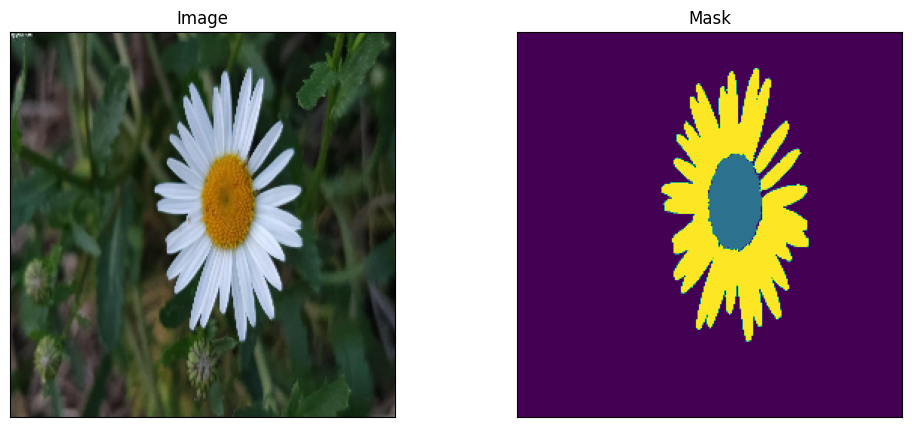

In [5]:
# объявим датасет, чтобы посмотреть на данные
dataset_path = "dataset/train"
dataset = DatasetBuilder(dataset_path)

# получим некий пример
image, mask = dataset[50]

plot_pair(image=image, mask=mask)

In [6]:
ENCODER_NAME = 'efficientnet-b7'
ENCODER_WEIGHTS = 'imagenet'

batch_size = 8
n_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = smp.Unet(
    encoder_name=ENCODER_NAME,
    encoder_weights=ENCODER_WEIGHTS,
    in_channels=3,
    classes=1,
    activation='sigmoid'
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER_NAME, ENCODER_WEIGHTS)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth
100%|██████████| 254M/254M [00:06<00:00, 38.4MB/s]


In [7]:
#апрейд функции тензора для добавления новой оси для двумерных масок
def to_tensor(x, **kwargs):
    if x.ndim == 2:
        x = x[..., np.newaxis]  # добавление новой оси для двумерных масок
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    _transform = [albu.Lambda(image=preprocessing_fn), albu.Lambda(image=to_tensor, mask=to_tensor)]
    return albu.Compose(_transform)

In [8]:
# датасеты + даталоадеры
dataset = DatasetBuilder(dataset_path, preprocessing=get_preprocessing(preprocessing_fn))
valid_size = int(len(dataset) * 0.2)
train_set, valid_set = torch.utils.data.random_split(dataset, (len(dataset)-valid_size, valid_size))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=0)

In [9]:
loss = smp_utils.losses.DiceLoss()
metrics = [smp_utils.metrics.IoU(threshold=0.3)]
optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=0.002),])

train_epoch = smp_utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp_utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=device,
    verbose=True,
)

max_score = 0

In [10]:
# обучение
for i in range(n_epochs):
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    # сохранение лучшей модели
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('best model saved')


Epoch: 0
valid: 100%|██████████| 90/90 [00:27<00:00,  3.23it/s, dice_loss - 0.5076, iou_score - 0.327]
best model saved

Epoch: 1
valid: 100%|██████████| 90/90 [00:28<00:00,  3.17it/s, dice_loss - 0.507, iou_score - 0.3272]
best model saved

Epoch: 2
valid: 100%|██████████| 90/90 [00:28<00:00,  3.20it/s, dice_loss - 0.5068, iou_score - 0.3274]
best model saved

Epoch: 3
valid: 100%|██████████| 90/90 [00:28<00:00,  3.20it/s, dice_loss - 0.5065, iou_score - 0.3276]
best model saved

Epoch: 4
valid: 100%|██████████| 90/90 [00:27<00:00,  3.22it/s, dice_loss - 0.5066, iou_score - 0.3276]

Epoch: 5
valid: 100%|██████████| 90/90 [00:27<00:00,  3.22it/s, dice_loss - 0.9414, iou_score - 0.03073]

Epoch: 6
valid: 100%|██████████| 90/90 [00:28<00:00,  3.21it/s, dice_loss - 0.8277, iou_score - 0.0991]

Epoch: 7
valid: 100%|██████████| 90/90 [00:27<00:00,  3.22it/s, dice_loss - 0.5065, iou_score - 0.3276]

Epoch: 8
valid: 100%|██████████| 90/90 [00:27<00:00,  3.23it/s, dice_loss - 0.5064, iou_scor

In [11]:
'''Тестируем на примере одной картинки'''
testDataset = DatasetBuilder('dataset/test', preprocessing=get_preprocessing(preprocessing_fn))
test_loader = torch.utils.data.DataLoader(testDataset, batch_size=batch_size, shuffle=True, num_workers=0)


def IoU_calc(mask, result_mask):
  h, w = mask.shape
  tp, fp, fn = 0, 0, 0
  # циклом по пикселям пробег: TP+=1 если верно, FN+=1 если маска принята за фон, FP+=1 если фон принят за маску
  for i in range(h):
    for j in range(w):
      if mask[i][j] == 255 and result_mask[i][j] == 255:
        tp += 1
      elif mask[i][j] == 255 and result_mask[i][j] == 0:
        fn += 1
      elif mask[i][j] == 0 and result_mask[i][j] == 255:
        fp += 1

  return tp / (tp + fp + fn)


model.eval()
with torch.no_grad():
  for image, mask in test_loader:
    image, mask = image.to(device), mask.to(device)
    output = model(image)
    result_mask = np.uint8(255.*output.cpu().numpy()[0].transpose(1,2,0))[..., 0]
    mask = np.uint8(255.*mask.cpu().numpy()[0].transpose(1,2,0))[..., 0]
    mask = np.where(mask > threshold_otsu(mask), 255, 0).astype(np.uint8)

    image = image.cpu().numpy()[0].transpose(1,2,0)
    image[..., 0] = image[..., 0] * 0.229 + 0.485
    image[..., 1] = image[..., 1] * 0.224 + 0.456
    image[..., 2] = image[..., 2] * 0.225 + 0.406

    image = np.uint8(255*image)
    break

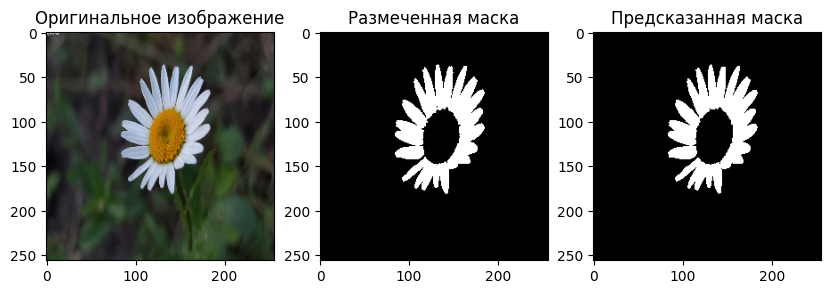

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes[0].imshow(image)
axes[0].set_title('Оригинальное изображение')
axes[1].imshow(mask, cmap='gray')
axes[1].set_title('Размеченная маска')
axes[2].imshow(result_mask, cmap='gray')
axes[2].set_title('Предсказанная маска')
plt.show()


In [13]:
print(f'Unet IoU: {IoU_calc(mask, result_mask):.5f}')

Unet IoU: 0.98642


Неплохой результат!

# 2. DBSCAN

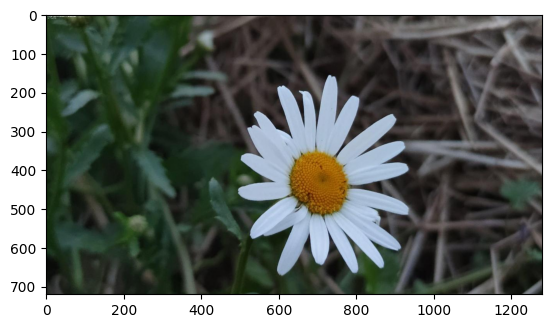

In [14]:
img = cv2.imread("dataset/test/images/image00005750.jpg")[..., :3][..., ::-1]
plt.imshow(img)

In [15]:
'''Вспомогательная функция для просмотра изображения поканально'''
def imageshow(img):
  r, g, b = cv2.split(img)

  thresh_r = threshold_otsu(r)
  thresh_g = threshold_otsu(g)
  thresh_b = threshold_otsu(b)


  r_1 = np.where(r > threshold_otsu(r), 255, 0).astype(np.uint8)
  g_1 = np.where(g > threshold_otsu(g), 255, 0).astype(np.uint8)
  b_1 = np.where(g > threshold_otsu(g), 255, 0).astype(np.uint8)

  fig, axes = plt.subplots(1, 3, figsize=(10, 5))
  axes[0].imshow(r_1, cmap='gray')
  axes[0].set_title('Red Channel')
  axes[1].imshow(g_1, cmap='gray')
  axes[1].set_title('Green Channel')
  axes[2].imshow(b_1, cmap='gray')
  axes[2].set_title('Blue Channel')
  plt.show()
  return cv2.merge([r_1, g_1, b_1])

In [16]:
'''Формирование "датасета" для DBSCAN'''
image_np = np.array(img)
h, w, c = image_np.shape
X = []
for i in range(h):
    for j in range(w):
        X.append([i, j, image_np[i, j, 0], image_np[i, j, 1], image_np[i, j, 2]])
X = np.array(X)

In [ ]:
'''Для подбора параметров'''
# min_samples = range(15, 40, 5) # Фиксируем min_samples
# eps_values = np.linspace(5, 1, 15) #  Диапазон значений eps
# n_clusters_values = []

# for eps in eps_values:
#   for samples in  min_samples:
#     db = DBSCAN(eps=eps, min_samples=samples)
#     labels = db.fit_predict(X)
#     labels = labels[labels != -1]
#     n_clusters = len(set(labels)) - (1 if -1 in labels else 0) #  Количество кластеров (исключая шум)
#     print(n_clusters)
#     n_clusters_values.append([eps, samples, n_clusters])


# import seaborn as sns
# plt.figure(figsize=(10, 5))
# sns.lineplot(x=[i[1] for i in n_clusters_values], y=[i[2] for i in n_clusters_values], marker='o')
# plt.xlabel('eps')
# plt.ylabel('Number of Clusters')
# plt.title('Number of Clusters vs. eps')


# plt.tight_layout()
# plt.show()

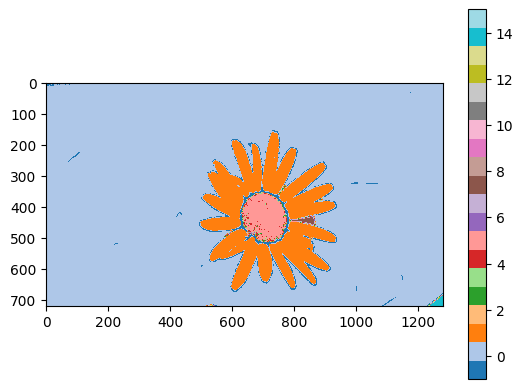

In [17]:
'''С оптимальными параметрами eps и min_samples'''
dbscan = DBSCAN(eps=12, min_samples=25)
labels = dbscan.fit_predict(X)
segmented_image = labels.reshape(h, w)

plt.imshow(segmented_image, cmap='tab20')
plt.colorbar()
plt.show()

AxesImage(shape=(720, 1280, 3))


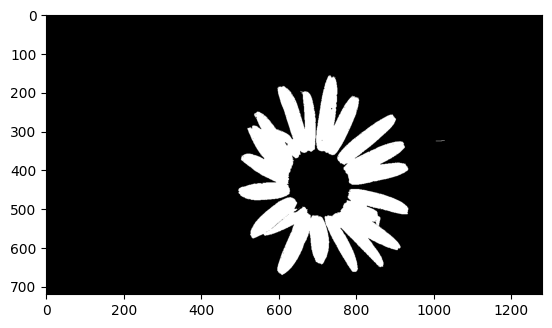

In [18]:
'''Предсказание алгоритмом DBSCAN img_new'''
img_new = img
flag = True
min_label, max_label = 1, 2 # лейблы нужного нам кластера
for i in range(segmented_image.shape[0]):
  for j in range(segmented_image.shape[1]):
    if segmented_image[i][j] >= min_label and segmented_image[i][j] <= max_label:
      img_new[i][j][0] = 255
      img_new[i][j][1] = 255
      img_new[i][j][2] = 255
    else:
      flag = False
      img_new[i][j][0] = 0
      img_new[i][j][1] = 0
      img_new[i][j][2] = 0
print(plt.imshow(img_new))

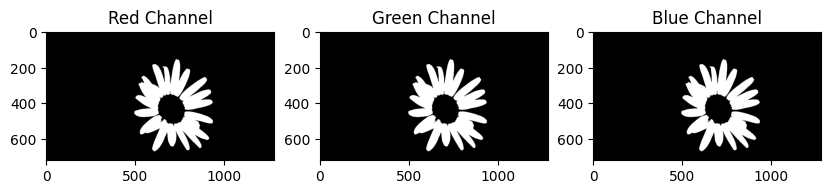

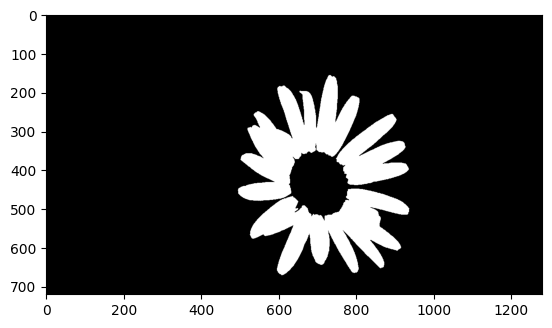

In [19]:
'''Загруженная маска изображения'''
img = cv2.imread("dataset/test/masks/mask00005750.png")[..., :3][..., ::-1]
img = imageshow(img)
plt.imshow(img)

In [20]:
'''Функция для расчета IoU (пришлось переписать, тут не 2D, а 3D)'''
def IoU_calc(mask, result_mask):
  h, w, c = mask.shape
  tp, fp, fn = 0, 0, 0
  # циклом по пикселям пробег: TP+=1 если верно, FN+=1 если маска принята за фон, FP+=1 если фон принят за маску
  for i in range(h):
    for j in range(w):
      if mask[i][j][0] == 255 and result_mask[i][j][0] == 255:
        tp += 1
      elif mask[i][j][0] == 255 and result_mask[i][j][0] == 0:
        fn += 1
      elif mask[i][j][0] == 0 and result_mask[i][j][0] == 255:
        fp += 1

  return tp / (tp + fp + fn)

print(f'DBscan IoU: {IoU_calc(img, img_new):.4f}')

DBscan IoU: 0.9336


# Вывод

Была реализована сегментация с помощью DBSCAN и UNet.
Подходы сравнивались с помощью метрики IoU.
В результате получилось:\
UNet IoU = 0.9864 \
DBSCAN IoU = 0.9336

Очевидно, что модель UNet лучше справляется с задачей сегментации, однако DBSCAN продемонстрировал себя тоже вполне неплохо.